In [1]:

rm(list=ls()); gc()
library(sf)
library(dplyr)
library(ggplot2)

load("/data/afg_satellite/xtai/afghanShapeAllInfo.Rdata")

covariates <- readRDS("/home/xtai/climate/3-8-23migrationCleanCode/output/3-13-23covariates.rds") %>%
  select(-geometry)

afghanShape <- afghanShape %>% select("DISTID", "geometry") %>%
  left_join(covariates %>% 
              filter(year == 2014), 
            by = c("DISTID" = "distid")) %>% mutate(prov = floor(DISTID/100)) 

################### tower groups 

towerGroups <- read.csv("/data/afg_anon/tower_datasets/tower_groups/v2020/tower_groups.csv")
towerGroups <- towerGroups %>%
  filter(tower_group_latitude < 40 & tower_group_longitude > 60.12) 

sites <- sf::st_as_sf(towerGroups, coords = c("tower_group_longitude", "tower_group_latitude"), 
                      crs = 4326) %>% 
  sf::st_transform(crs = 32642)


districts <- sf::st_intersects(afghanShape, sites, sparse = FALSE) # this is 398 by 2716 --- each event is on a column
whichDistricts <- apply(districts, MARGIN = 2, FUN = function(x) which(x == TRUE)) # this will only work with points
distIDs <- afghanShape$DISTID[unlist(whichDistricts)]
length(unique(distIDs)) # 292
afghanShape$phoneData <- ifelse(afghanShape$DISTID %in% distIDs, 1, 0)
xtabs(~ phoneData + poppyCat, data = afghanShape) 


sel_model <- glm(phoneData ~  poppyCat + log(areakm2) + log(nonPoppy2) + TOTAL + 
                 as.factor(prov) + provincialCapital + cultivatedFrac + roadDensity + builtUpFracPop + trackPathFrac
                 + healthPer100000 + diversity + as.factor(majority) + barrenAreaFrac + notGovt , 
                 family = binomial(), data = afghanShape)

afghanShape$ps <- NA
afghanShape$ps[as.numeric(rownames(sel_model$model))] <- predict(sel_model, type = "response")

afghanShape <- afghanShape %>%
  mutate(ipw = ifelse(phoneData == 1, 1 / ps, NA))

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,658617,35.2,1454127,77.7,1318360,70.5
Vcells,1225688,9.4,8388608,64.0,1975970,15.1


Linking to GEOS 3.7.2, GDAL 3.0.4, PROJ 6.3.2; sf_use_s2() is TRUE


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] 292

         poppyCat
phoneData   N   L   H
        0  60  36  10
        1 206  55  31

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   1.000   1.028   1.271   1.212  11.388       5 

90%      95%      99% 
1.675164 2.071609 4.951324

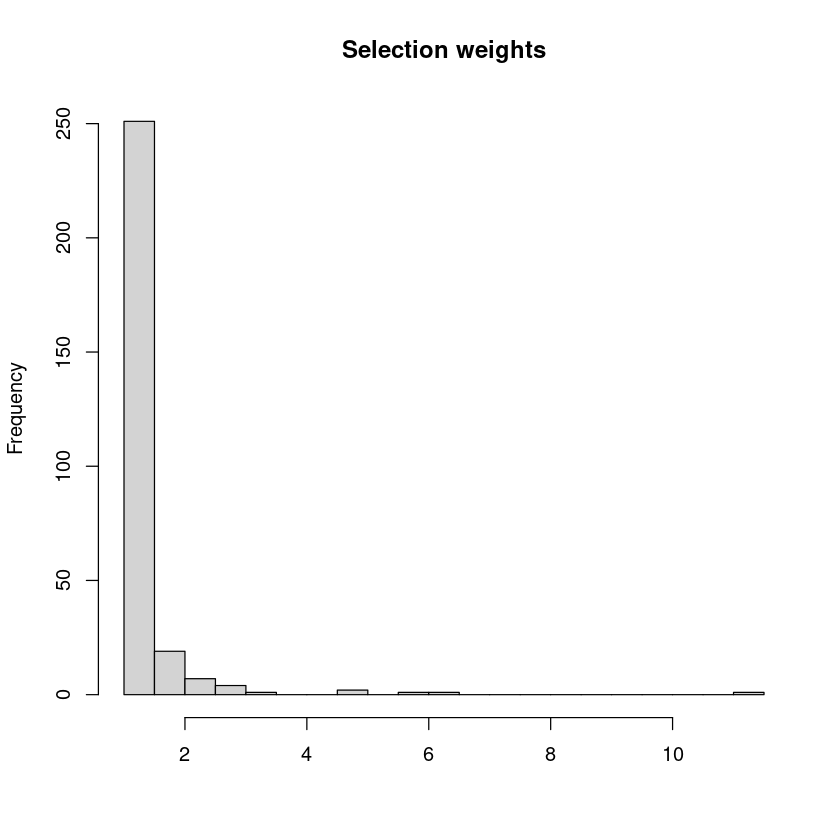

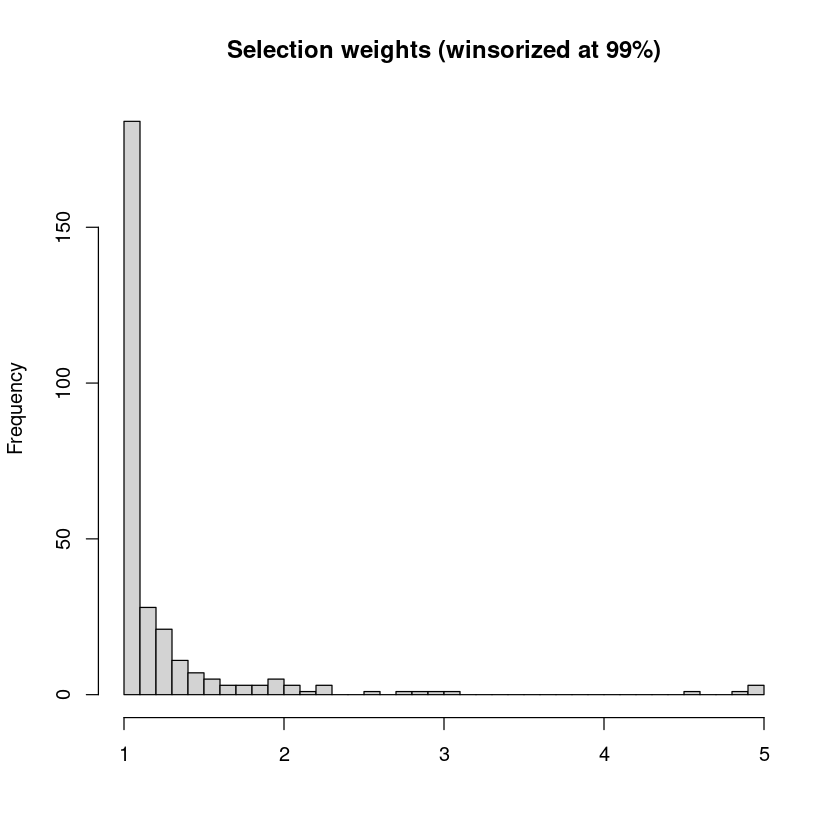

In [2]:
## check distribution of weights for districts with phone data
selected <- subset(afghanShape, afghanShape$phoneData == 1)

summary(selected$ipw)
par(bg = 'white')
hist(selected$ipw, breaks = 30, 
     main = "Selection weights", xlab = "")

quantile(selected$ipw, probs = c(0.9, 0.95, 0.99), na.rm = TRUE)

selected$ipw_w99 <- ifelse(selected$ipw > 4.951324257507, 4.951324257507, selected$ipw) 

hist(selected$ipw_w99, breaks = 30, 
     main = "Selection weights (winsorized at 99%)", xlab = "")


#### Fig 2 D Reanalysis

In [3]:
# rm(list = ls()); gc()
outcome1 <- readRDS("/home/xtai/climate/3-8-23migrationCleanCode/output/6-5-23inMigRegOutcome_2020.rds")
covariates <- readRDS("/home/xtai/climate/3-8-23migrationCleanCode/output/3-13-23covariates.rds") %>%
  dplyr::select(-geometry) # this version should have poppyCat, talibanCurrent and inaccessibleCurrent

outDTFM4 <- covariates %>%
  left_join(outcome1, by = c("distid", "year")) %>%
  mutate(prov = floor(distid/100)) %>%
  filter(!is.na(maxIn)) 

outDTFM4 <- outDTFM4 %>% left_join(selected %>% select(DISTID, ipw_w99) %>% st_drop_geometry, by = c('distid' = 'DISTID'))

df_tmp <- outDTFM4 %>%
             filter(!is.na(maxIn))
# categorical version
fit1 <- lm(maxIn ~ poppyCat + log(areakm2) + 
             log(nonPoppy2) + TOTAL + as.factor(year) + as.factor(prov) +
             provincialCapital + cultivatedFrac + roadDensity + builtUpFracPop +
             trackPathFrac + healthPer100000 + diversity + as.factor(majority)+
             barrenAreaFrac, 
           data = df_tmp)

# fit1coefs <- lmtest::coeftest(fit1, vcov. = sandwich::vcovCL(fit1, cluster = fit1$model$`as.factor(prov)`, type = "HC1")) 
# the ones I want are poppyCatL and poppyCatH
tmpDistID <- outDTFM4$distid[!is.na(outDTFM4$maxIn) & !is.na(outDTFM4$diversity) & !is.na(outDTFM4$trackPathFrac)]
fit1coefs <- lmtest::coeftest(fit1, vcov. = sandwich::vcovCL(fit1, cluster = as.factor(tmpDistID), type = "HC1")) # takes less than a minute!


# categorical version with selection weights
fit1w <- lm(maxIn ~ poppyCat + log(areakm2) + 
             log(nonPoppy2) + TOTAL + as.factor(year) + as.factor(prov) +
             provincialCapital + cultivatedFrac + roadDensity + builtUpFracPop +
             trackPathFrac + healthPer100000 + diversity + as.factor(majority)+
             barrenAreaFrac, 
           data = df_tmp, 
           weights = df_tmp$ipw_w99)

# fit1coefs <- lmtest::coeftest(fit1, vcov. = sandwich::vcovCL(fit1, cluster = fit1$model$`as.factor(prov)`, type = "HC1")) 
# the ones I want are poppyCatL and poppyCatH
tmpDistID <- outDTFM4$distid[!is.na(outDTFM4$maxIn) & !is.na(outDTFM4$diversity) & !is.na(outDTFM4$trackPathFrac)]
fit1wcoefs <- lmtest::coeftest(fit1w, vcov. = sandwich::vcovCL(fit1w, cluster = as.factor(tmpDistID), type = "HC1")) # takes less than a minute!



,model,label,estimate,CIlow,CIhigh
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
poppyCatL,Overall,Low-cultivation,-0.001503304,-0.007020027,0.004013419
poppyCatH,Overall,High-cultivation,0.027089737,0.010629456,0.043550018


[1] 0.001256662

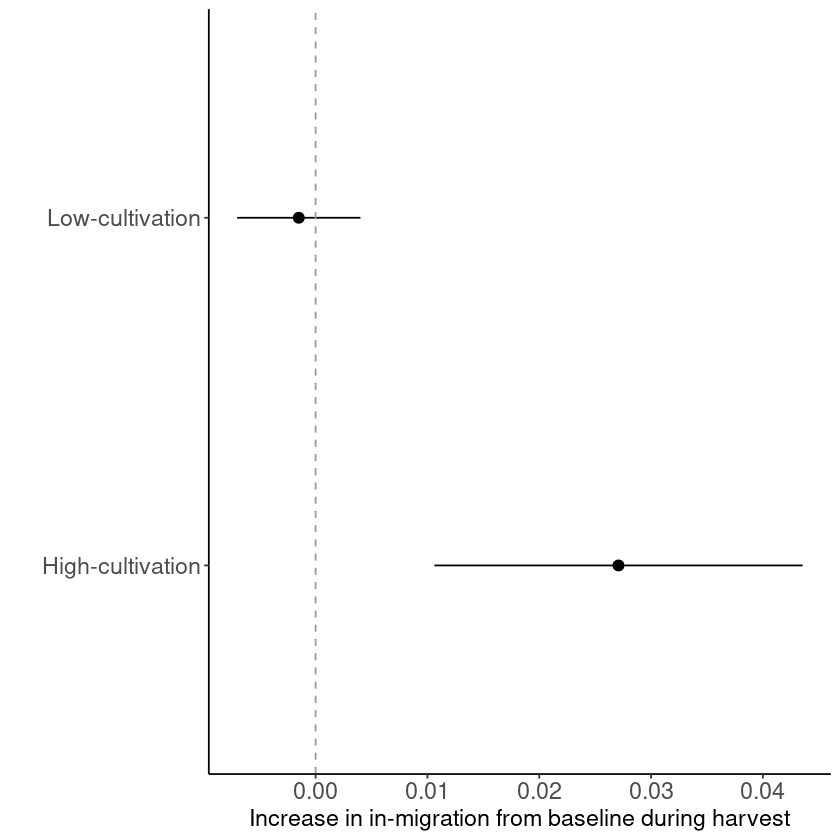

In [7]:
##### Replicate 2D currently in paper

tmp <- fit1coefs[c("poppyCatL", "poppyCatH"), c("Estimate", "Std. Error")]
plotDTF <- data.frame(model = "Overall", label = c("Low-cultivation", "High-cultivation"), estimate = tmp[, "Estimate"], CIlow = tmp[, "Estimate"] - 1.96*tmp[, "Std. Error"], CIhigh = tmp[, "Estimate"] + 1.96*tmp[, "Std. Error"])
plotDTF
plot1 <- plotDTF %>%
  ggplot(aes(label, estimate)) +
  theme_classic()+
  geom_pointrange(aes(ymin = CIlow, ymax = CIhigh),
                  # position = position_dodge(width = .4),
                  # size = .4, fatten = 2) +
                  # size = 1.4, fatten = 2
  ) + # fatten changes the circles only; size changes bars and legend circles
  coord_flip() + 
  geom_hline(yintercept = 0, colour = "grey60", linetype = 2) + 
  guides(color = guide_legend(override.aes = list(linetype = "blank")), scale = 'none',  
         # linetype = guide_legend(override.aes = list(shape = NA))
         linetype = FALSE # suppress line for first plot; only do color
  ) +  # shape for the type of dot
  # scale_y_continuous(limits = c(-.002, .032)) +
  theme(axis.text = element_text(size = 14),
        axis.title=element_text(size=14)
  ) +
  labs(#title = paste0("Effect of violence on destination of movers: non-capitals"),
    y = "Increase in in-migration from baseline during harvest",
    x = "",
  ) 

plot1
2*pnorm(tmp[2, 1]/tmp[2, 2], lower.tail = FALSE)

Updated text based on figure with weights

Figure \ref{fig:fig2}D, imply that on average, high-poppy cultivating districts have a mean daily increase in harvest in-migration of 2.7\% (95\% C.I.: (1.06, 4.36)\%, $P = 0.001$)

,model,label,estimate,CIlow,CIhigh
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
poppyCatL,Overall,Low-cultivation,-0.002197664,-0.007443578,0.00304825
poppyCatH,Overall,High-cultivation,0.025857902,0.009892405,0.04182340


[1] 0.001501267

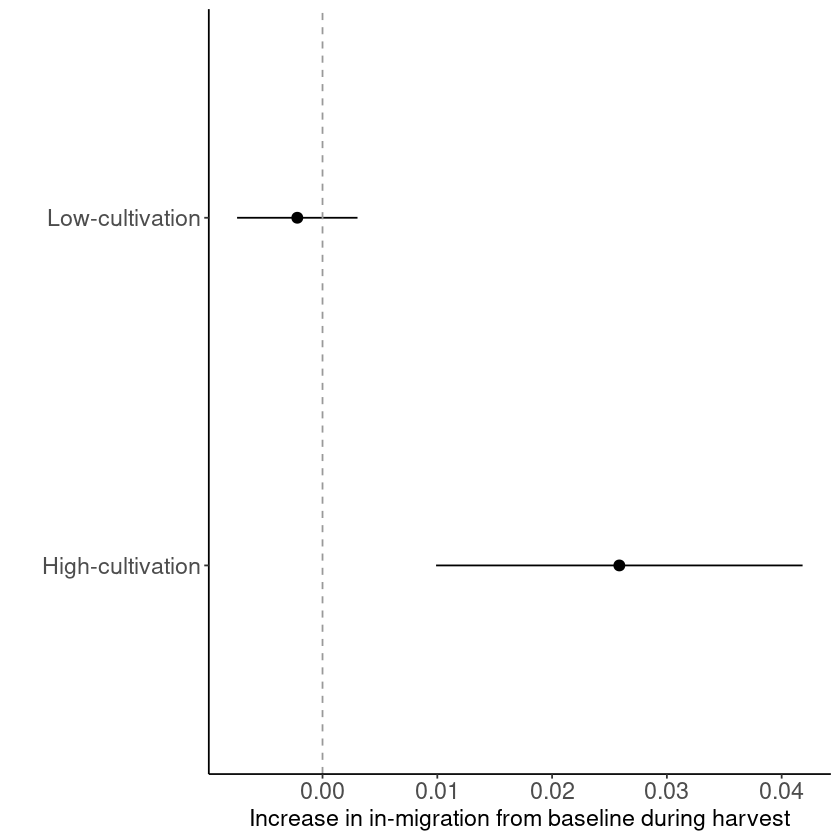

In [8]:
### Figure 2 D with selection weights
tmp <- fit1wcoefs[c("poppyCatL", "poppyCatH"), c("Estimate", "Std. Error")]
plotDTF <- data.frame(model = "Overall", label = c("Low-cultivation", "High-cultivation"), estimate = tmp[, "Estimate"], CIlow = tmp[, "Estimate"] - 1.96*tmp[, "Std. Error"], CIhigh = tmp[, "Estimate"] + 1.96*tmp[, "Std. Error"])
plotDTF
plot1 <- plotDTF %>%
  ggplot(aes(label, estimate)) +
  theme_classic()+
  geom_pointrange(aes(ymin = CIlow, ymax = CIhigh),
                  # position = position_dodge(width = .4),
                  # size = .4, fatten = 2) +
                  # size = 1.4, fatten = 2
  ) + # fatten changes the circles only; size changes bars and legend circles
  coord_flip() + 
  geom_hline(yintercept = 0, colour = "grey60", linetype = 2) + 
  guides(color = guide_legend(override.aes = list(linetype = "blank")), scale = 'none',  
         # linetype = guide_legend(override.aes = list(shape = NA))
         linetype = FALSE # suppress line for first plot; only do color
  ) +  # shape for the type of dot
  # scale_y_continuous(limits = c(-.002, .032)) +
  theme(axis.text = element_text(size = 14),
        axis.title=element_text(size=14)
  ) +
  labs(#title = paste0("Effect of violence on destination of movers: non-capitals"),
    y = "Increase in in-migration from baseline during harvest",
    x = "",
  ) 

plot1
2*pnorm(tmp[2, 1]/tmp[2, 2], lower.tail = FALSE)

Updated text based on figure with weights

Figure \ref{fig:fig2}D, imply that on average, high-poppy cultivating districts have a mean daily increase in harvest in-migration of 2.6\% (95\% C.I.: (0.99, 4.2)\%, $P = 0.0015$)

#### Fig 3B Reanalysis

10% 20% 30% 40% 50% 60% 70% 80% 90% 
  0   0   0   0   0   0   0   2   9

10% 20% 30% 40% 50% 60% 70% 80% 90% 
0.0 0.0 0.0 0.0 0.0 0.0 0.3 1.0 2.0

pdf 
  2

model,label,estimate,CIlow,CIhigh,variance,p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>"
High-growing,"Violence N, Taliban N",0.005021049,-0.012893096,0.02293519,8.354029e-05,0.5827675679
High-growing,"Violence Y, Taliban N",0.015517353,-0.006726801,0.03776151,1.288059e-04,0.1715450804
High-growing,"Violence N, Taliban Y",0.037581359,0.008305667,0.06685705,2.231095e-04,0.0118689778
High-growing,"Violence Y, Taliban Y",0.032625379,0.013495150,0.05175561,9.526737e-05,0.0008299957


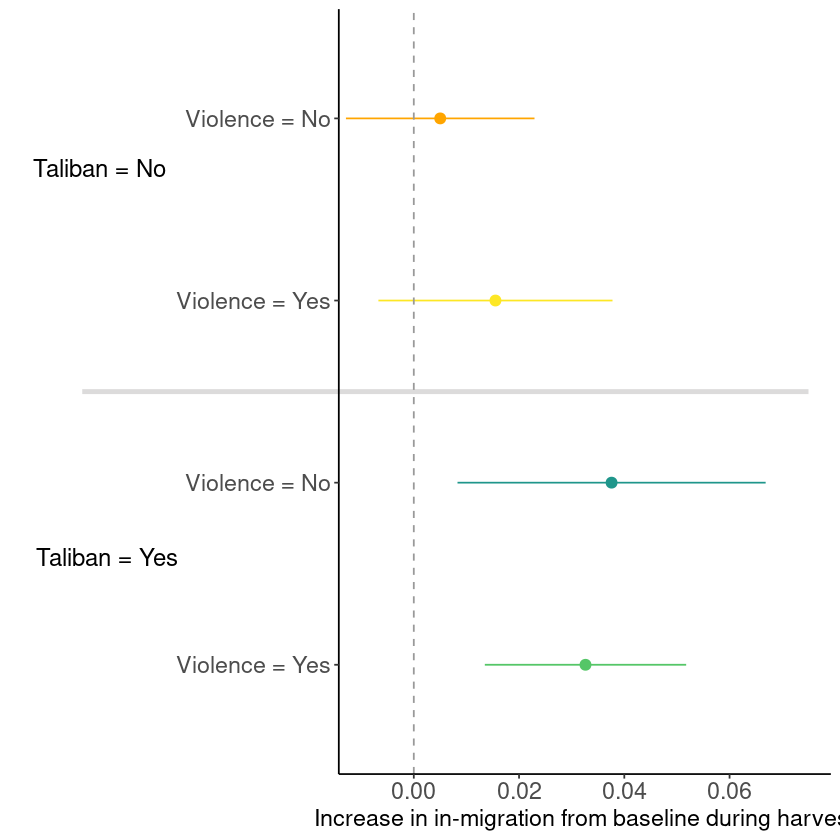

In [10]:
######### Replicate Fig 3B currently in paper
# rm(list = ls()); gc()
library(dplyr); library(ggplot2)
outcome1 <- readRDS("/home/xtai/climate/3-8-23migrationCleanCode/output/6-5-23inMigRegOutcome_2020.rds")
covariates <- readRDS("/home/xtai/climate/3-8-23migrationCleanCode/output/3-13-23covariates.rds") %>%
  dplyr::select(-geometry) # this version should have poppyCat, notGovt

newViolence <- readRDS("/home/xtai/climate/3-8-23migrationCleanCode/output/6-5-23violenceDest_2020.rds")

outDTFM4 <- covariates %>%
  left_join(outcome1, by = c("distid", "year")) %>%
  mutate(prov = floor(distid/100)) %>%
  left_join(newViolence %>%
            mutate(violence_monthBefore = ifelse(numEvents_monthBeforePeak > 0, 1, 0)), #%>% # ORIGINAL
            by = c("distid", "year")) %>%
  filter(!is.na(maxIn)) # %>%

outDTFM4 <- outDTFM4 %>% left_join(selected %>% select(DISTID, ipw_w99) %>% st_drop_geometry, by = c('distid' = 'DISTID'))


### quantiles for SI
quantile(outDTFM4$numCas_monthBeforePeak, seq(.1, .9, by = .1))


quantile(outDTFM4$numEvents_monthBeforePeak, seq(.1, .9, by = .1))

                           
################ fig 3b reanalysis

data_tmp <- outDTFM4 %>%
             filter(!is.na(maxIn) 
             )%>%
             rename(violence = violence_monthBefore) %>%
             mutate(taliban = ifelse(notGovt, 1, 0))

new3 <- lm(maxIn ~ poppyCat*violence*taliban + log(areakm2) + log(nonPoppy2) + TOTAL + as.factor(year) + as.factor(prov) +
             provincialCapital + cultivatedFrac + roadDensity + builtUpFracPop +
             trackPathFrac + healthPer100000 + diversity + as.factor(majority)+
             barrenAreaFrac, 
           data = data_tmp,
          weights = data_tmp$ipw_w99)

# fit2coefs <- lmtest::coeftest(new3, vcov. = sandwich::vcovCL(new3, cluster = new3$model$`as.factor(prov)`, type = "HC1")) # takes less than a minute!

tmpDistID <- outDTFM4$distid[!is.na(outDTFM4$maxIn) & !is.na(outDTFM4$diversity) & !is.na(outDTFM4$trackPathFrac)]
fit2coefs <- lmtest::coeftest(new3, vcov. = sandwich::vcovCL(new3, cluster = as.factor(tmpDistID), type = "HC1")) # takes less than a minute!


keepNames <- c("poppyCatH", "violence", "poppyCatH:violence", "taliban", "poppyCatH:taliban", "violence:taliban", "poppyCatH:violence:taliban")
# keepNames <- c("poppyCatL", "violence", "poppyCatL:violence", "taliban", "poppyCatL:taliban", "poppyCatL:violence:taliban")
estimates <- fit2coefs[keepNames, "Estimate"] # keeps the order of names too 
# clusteredVcov <- sandwich::vcovCL(new3, cluster = new3$model$`as.factor(prov)`, type = "HC1")
clusteredVcov <- sandwich::vcovCL(new3, cluster = as.factor(tmpDistID), type = "HC1")
clusteredVcov <- clusteredVcov[keepNames, keepNames]

# vecs of interest:
getCI <- function(myVec, estimates, vCov){
  # estimate is vec*estimates;  variance is vec*clusteredVcov*vec
  estimate <- myVec %*% estimates
  variance <- myVec %*% vCov %*% myVec
  ciLow <- estimate - qnorm(.975)*sqrt(variance)
  ciHigh <- estimate + qnorm(.975)*sqrt(variance)
  ret <- list(estimate = estimate, variance = variance, ciLow = ciLow, ciHigh = ciHigh)
  return(ret)
}

outDTF <- data.frame(model = rep("High-growing", 4), 
                     label = c("Violence N, Taliban N",
                               "Violence Y, Taliban N",
                               "Violence N, Taliban Y",
                               "Violence Y, Taliban Y"),
                     estimate = NA,
                     CIlow = NA,
                     CIhigh = NA)

vecs <- list(c(1, 0, 0, 0, 0, 0, 0),
             c(1, 1, 1, 0, 0, 0, 0),
             c(1, 0, 0, 1, 1, 0, 0),
             c(1, 1, 1, 1, 1, 1, 1))
for (i in 1:4) {
  tmp <- getCI(myVec = vecs[[i]], estimates = estimates, vCov = clusteredVcov)
  outDTF[i, "estimate"] <- tmp$estimate
  outDTF[i, "CIlow"] <- tmp$ciLow
  outDTF[i, "CIhigh"] <- tmp$ciHigh
  outDTF[i, "variance"] <- tmp$variance
}

##### Figure 3B with selection weights
plot1 <- outDTF %>%
  mutate(label = paste0(4:1, label)) %>%
  ggplot(aes(label, estimate))+
  geom_pointrange(aes(ymin = CIlow, ymax = CIhigh),
                  color = c("orange", "#fde725", "#1f968b", "#55c667")
  ) + # fatten changes the circles only; size changes bars and legend circles
  theme_classic() + 
  geom_hline(yintercept = 0, colour = "grey60", linetype = 2) + 
  guides(color = guide_legend(override.aes = list(linetype = "blank")), scale = 'none', 
         linetype = FALSE # suppress line for first plot; only do color
  ) +  # shape for the type of dot
  theme(plot.title = element_text(size = 15, face = "bold"),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14),
  ) +
  labs(#title = paste0("Effect of violence on destination of movers: non-capitals"),
    # title = "Violence definition: any violent event", 
    y = "Increase in in-migration from baseline during harvest",
    x = ""
  ) +
  labs(tag = "Taliban = No \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\ Taliban = Yes") +
  # labs(tag = "Violence = Yes \n\n\n\n\n Violence = No") +
  theme(plot.tag.position = c(-.07, .57),
        text = element_text(size = 12),
        plot.margin = theme_get()$plot.margin + unit(c(0, 0, 0, 3), "cm")
  ) +
  coord_flip(clip = "off"
             , ylim = c(-.01, 0.075)
             # , ylim = c(-.03, 0.09) # for low-growing
  ) +
  annotate(x = 2.5, xend = 2.5, y = -.063, yend = .075,
           geom = "segment",
           colour = "#a8a5a5", size = 1.4, alpha = .4) +
  # geom_vline(xintercept = 2.5, colour = "grey60", linetype = 2) +
  scale_x_discrete(labels = c("Violence = Yes", "Violence = No", "Violence = Yes", "Violence = No")) # bottom to top 
# scale_x_discrete(labels = c("Taliban = No", "Taliban = Yes", "Taliban = No", "Taliban = Yes")) # bottom to top 


pdf(paste0("fig_11-2-25fig3b_with_weights.pdf"), width = 8, height = 3)
gridExtra::grid.arrange(plot1, nrow = 1)
dev.off()

plot1
outDTF$p <- 2*pnorm(abs(outDTF$estimate)/sqrt(outDTF$variance), lower.tail = FALSE)
outDTF

Paragraph for test (filling in from table above):

In high-cultivation districts, those with violence and Taliban presence experience 3.3\% (95\% C.I.: (1.35, 5.2)\%, $P < 0.001$) larger increases in harvest in-migration, relative to the reference group with no poppy cultivation and no conflict, which is similar to what occurs in districts with Taliban presence but no violence (3.8\%; 95\% C.I.: (0.83%, 6.69)\%, $P = 0.012$). Districts without Taliban presence see much smaller increases regardless of whether they experience violence or not: 1.5\% for districts with violence (95\% C.I.: (-0.67, 3.78)\%, $P = 0.172$) and 0.5\% for those without (95\% C.I.: (-1.29, 2.29)\%, $P = 0.582$).

model,label,estimate,CIlow,CIhigh,variance,p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>"
High-growing,"Violence N, Taliban N",0.009800947,-0.006935413,0.02653731,7.291650e-05,0.2510632428
High-growing,"Violence Y, Taliban N",0.008594161,-0.007304609,0.02449293,6.580075e-05,0.2893864488
High-growing,"Violence N, Taliban Y",0.041531303,0.009666228,0.07339638,2.643222e-04,0.0106335407
High-growing,"Violence Y, Taliban Y",0.033540215,0.014161149,0.05291928,9.776187e-05,0.0006933451


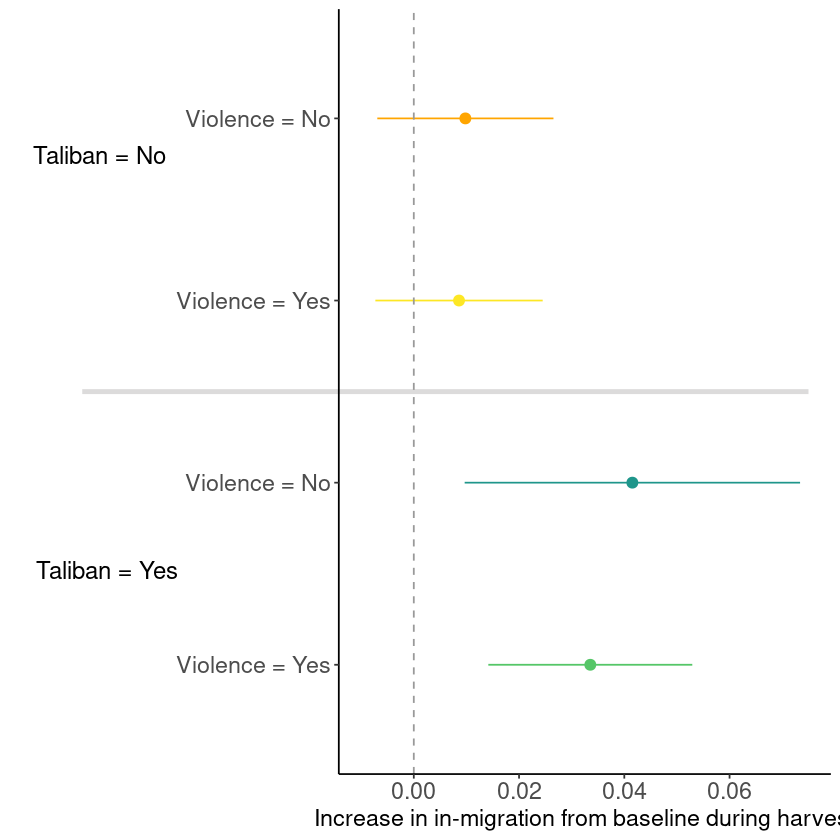

In [8]:
#### Replicate Fig 3b in paper
new3 <- lm(maxIn ~ poppyCat*violence*taliban + log(areakm2) + log(nonPoppy2) + TOTAL + as.factor(year) + as.factor(prov) +
             provincialCapital + cultivatedFrac + roadDensity + builtUpFracPop +
             trackPathFrac + healthPer100000 + diversity + as.factor(majority)+
             barrenAreaFrac, 
           data = data_tmp)

# fit2coefs <- lmtest::coeftest(new3, vcov. = sandwich::vcovCL(new3, cluster = new3$model$`as.factor(prov)`, type = "HC1")) # takes less than a minute!

tmpDistID <- outDTFM4$distid[!is.na(outDTFM4$maxIn) & !is.na(outDTFM4$diversity) & !is.na(outDTFM4$trackPathFrac)]
fit2coefs <- lmtest::coeftest(new3, vcov. = sandwich::vcovCL(new3, cluster = as.factor(tmpDistID), type = "HC1")) # takes less than a minute!
keepNames <- c("poppyCatH", "violence", "poppyCatH:violence", "taliban", "poppyCatH:taliban", "violence:taliban", "poppyCatH:violence:taliban")
estimates <- fit2coefs[keepNames, "Estimate"] # keeps the order of names too 

clusteredVcov <- sandwich::vcovCL(new3, cluster = as.factor(tmpDistID), type = "HC1")
clusteredVcov <- clusteredVcov[keepNames, keepNames]

# vecs of interest:
getCI <- function(myVec, estimates, vCov){
  # estimate is vec*estimates;  variance is vec*clusteredVcov*vec
  estimate <- myVec %*% estimates
  variance <- myVec %*% vCov %*% myVec
  ciLow <- estimate - qnorm(.975)*sqrt(variance)
  ciHigh <- estimate + qnorm(.975)*sqrt(variance)
  ret <- list(estimate = estimate, variance = variance, ciLow = ciLow, ciHigh = ciHigh)
  return(ret)
}

outDTF <- data.frame(model = rep("High-growing", 4), 
                     label = c("Violence N, Taliban N",
                               "Violence Y, Taliban N",
                               "Violence N, Taliban Y",
                               "Violence Y, Taliban Y"),
                     estimate = NA,
                     CIlow = NA,
                     CIhigh = NA)

vecs <- list(c(1, 0, 0, 0, 0, 0, 0),
             c(1, 1, 1, 0, 0, 0, 0),
             c(1, 0, 0, 1, 1, 0, 0),
             c(1, 1, 1, 1, 1, 1, 1))
for (i in 1:4) {
  tmp <- getCI(myVec = vecs[[i]], estimates = estimates, vCov = clusteredVcov)
  outDTF[i, "estimate"] <- tmp$estimate
  outDTF[i, "CIlow"] <- tmp$ciLow
  outDTF[i, "CIhigh"] <- tmp$ciHigh
  outDTF[i, "variance"] <- tmp$variance
}

plot1 <- outDTF %>%
  mutate(label = paste0(4:1, label)) %>%
  ggplot(aes(label, estimate))+
  geom_pointrange(aes(ymin = CIlow, ymax = CIhigh),
                  color = c("orange", "#fde725", "#1f968b", "#55c667")
  ) + # fatten changes the circles only; size changes bars and legend circles
  theme_classic() + 
  geom_hline(yintercept = 0, colour = "grey60", linetype = 2) + 
  guides(color = guide_legend(override.aes = list(linetype = "blank")), 
         linetype = FALSE # suppress line for first plot; only do color
  ) +  # shape for the type of dot
  theme(plot.title = element_text(size = 15, face = "bold"),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14),
  ) +
  labs(#title = paste0("Effect of violence on destination of movers: non-capitals"),
    # title = "Violence definition: any violent event", 
    y = "Increase in in-migration from baseline during harvest",
    x = ""
  ) +
  labs(tag = "Taliban = No \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n Taliban = Yes") +
  # labs(tag = "Violence = Yes \n\n\n\n\n Violence = No") +
  theme(plot.tag.position = c(-.07, .57),
        text = element_text(size = 12),
        plot.margin = theme_get()$plot.margin + unit(c(0, 0, 0, 3), "cm")
  ) +
  coord_flip(clip = "off"
             , ylim = c(-.01, 0.075)
             # , ylim = c(-.03, 0.09) # for low-growing
  ) +
  annotate(x = 2.5, xend = 2.5, y = -.063, yend = .075,
           geom = "segment",
           colour = "#a8a5a5", size = 1.4, alpha = .4) +
  # geom_vline(xintercept = 2.5, colour = "grey60", linetype = 2) +
  scale_x_discrete(labels = c("Violence = Yes", "Violence = No", "Violence = Yes", "Violence = No")) # bottom to top 
# scale_x_discrete(labels = c(

plot1
outDTF$p <- 2*pnorm(abs(outDTF$estimate)/sqrt(outDTF$variance), lower.tail = FALSE)
outDTF

Current paragraph in text
In high-cultivation districts, those with violence and Taliban presence experience 3.4\% (95\% C.I.: (1.42, 5.29)\%, $P < 0.001$) larger increases in harvest in-migration, relative to the reference group with no poppy cultivation and no conflict, which is similar to what occurs in districts with Taliban presence but no violence (4.2\%; 95\% C.I.: (0.97, 7.34)\%, $P = 0.011$). Districts without Taliban presence see much smaller increases regardless of whether they experience violence or not: 0.86\% for districts with violence (95\% C.I.: (-0.73, 2.45)\%, $P = 0.289$) and 1.0\% for those without (95\% C.I.: (-0.69, 2.65)\%, $P = 0.251$).